###**Importing Necessary Libraries**

In [ ]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium 

###**Scraping the Neighborhoods(Areas) in Mumbai from the Wikipedia Page.**

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai#Other"
dfs = pd.read_html(url)

In [ ]:
neighborhood_df = dfs[0]
print(neighborhood_df.shape)
neighborhood_df.head(15)

(90, 4)


,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.120000,72.820000
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


###**Loading the Commercial Property Rate Data.**

In [ ]:
url_1 = 'For First Blog - Mumbai.csv'
property_rates_df = pd.read_csv(url_1)
print(property_rates_df.shape)
property_rates_df.head()

(93, 3)


,Area,Location,Rate
0,Amboli,"Andheri,Western Suburbs",18000.0
1,"Chakala, Andheri",Western Suburbs,14750.0
2,D.N. Nagar,"Andheri,Western Suburbs",18000.0
3,Four Bungalows,"Andheri,Western Suburbs",18000.0
4,Lokhandwala,"Andheri,Western Suburbs",18000.0


In [ ]:
mumbai_df = pd.merge(neighborhood_df, property_rates_df, on=['Area', 'Location'])
mumbai_df.dropna(inplace=True)
print(mumbai_df.shape)
mumbai_df.head()

(65, 5)


,Area,Location,Latitude,Longitude,Rate
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,18000.0
1,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,18000.0
2,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,18000.0
3,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,18000.0
4,Marol,"Andheri,Western Suburbs",19.119219,72.882743,14750.0


In [ ]:
new = mumbai_df["Location"].str.split(",", n = 1, expand = True) 
mumbai_df["Location"] = new[0] 
mumbai_df["Suburb"]= new[1] 

for i in range(mumbai_df.shape[0]):
    if mumbai_df.iloc[i, 5] is None:
        mumbai_df.iloc[i, 5] = mumbai_df.iloc[i, 1]

mumbai_df.reset_index(drop=True, inplace=True)
mumbai_df.head()

,Area,Location,Latitude,Longitude,Rate,Suburb
0,Amboli,Andheri,19.129300,72.843400,18000.0,Western Suburbs
1,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs
2,Four Bungalows,Andheri,19.124714,72.827210,18000.0,Western Suburbs
3,Lokhandwala,Andheri,19.130815,72.829270,18000.0,Western Suburbs
4,Marol,Andheri,19.119219,72.882743,14750.0,Western Suburbs


In [ ]:
mumbai_df.shape

(65, 6)

###**Plotting all Areas on Map showing respective Property Rates.**

In [ ]:
address = 'Bandra, Mumbai city, India'

geolocator = Nominatim(user_agent="mum_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.0380606, 72.8174664.


In [ ]:
rate_range = np.linspace(mumbai_df.Rate.min(), mumbai_df.Rate.max(), 5)
rate_range

array([ 8000., 17250., 26500., 35750., 45000.])

####**Color Code**

High Property Rate - Black

Medium High Property Rate - Blue

Medium Low Property Rate - Red

Low Property Rate - Orange



In [ ]:
map_Areas = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, area, rate in zip(mumbai_df['Latitude'], mumbai_df['Longitude'], mumbai_df['Area'], mumbai_df['Rate']):
    col = 'orange' if rate<=rate_range[1] else 'red' if rate<=rate_range[2] else "blue" if rate<=rate_range[3] else "black"
    label = '{}, Rs.{}/sq.ft.'.format(area , int(rate))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= col ,
        fill=True,
        fill_color= col ,
        fill_opacity=0.5,
        parse_html=False).add_to(map_Areas)  
    
map_Areas

###**Using FourSquare API to collect JSON data of all nearby Schools, Colleges & Classes in each of the Areas**

In [ ]:
CLIENT_ID = 'Enter your foursquare ID here' # your Foursquare ID
CLIENT_SECRET = 'Enter your foursquare ID here' # your Foursquare Secret
VERSION = 'Enter Version here'
LIMIT = 50

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, query_list, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        for query in query_list:
            search_query = query
            url = "https://api.foursquare.com/v3/places/search?ll={}%2C{}&radius={}&query={}&limit={}".format(
                lat, lng, radius, search_query, LIMIT)
            
            # make the GET request
            results = requests.get(url, headers={"Accept":"application/json", "Authorization":"Enter foursquare api key here"})

            results = results.json()['results']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['geocodes']['main']['latitude'], 
                v['geocodes']['main']['longitude']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [ ]:
Schools_Colleges_df = getNearbyVenues(names=mumbai_df['Area'],
                                   latitudes=mumbai_df['Latitude'],
                                   longitudes=mumbai_df['Longitude'],
                                   query_list=['high school', 'college']
                                  )

Amboli
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Vikhroli
Chembur
Mankhurd
Altamount Road
Breach Candy
Churchgate
Cuffe Parade
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Matunga
Parel
Gowalia Tank


In [ ]:
from os import system
import requests

url = "https://api.foursquare.com/v3/places/search?ll=19.129300%2C72.843400&radius=2000&query=college"

results = requests.get(url, headers={"Accept":"application/json", "Authorization":"Enter foursquare api key here"})

results.json()['results'][0]

{'fsq_id': 'b69ea6734c1f4e203873e1ad',
 'categories': [{'id': 12013,
   'name': 'College and University',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/education/default_',
    'suffix': '.png'}}],
 'chains': [],
 'distance': 912,
 'geocodes': {'main': {'latitude': 19.124969, 'longitude': 72.836018}},
 'link': '/v3/places/b69ea6734c1f4e203873e1ad',
 'location': {'address': 'Munshi Nagar, Andheri West',
  'country': 'IN',
  'formatted_address': 'Munshi Nagar, Andheri West, Mumbai 400058, Maharashtra',
  'locality': 'Mumbai',
  'neighborhood': ['Andheri West'],
  'postcode': '400058',
  'region': 'Maharashtra'},
 'name': 'BHAVANS COLLEGE, andheri (w)',
 'related_places': {}}

In [ ]:
print(Schools_Colleges_df.shape)
Schools_Colleges_df.head() 

(3477, 6)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,Bhatia Commerce Classes,19.122438,72.846162
1,Amboli,19.1293,72.8434,Vissanji Academy,19.119911,72.852768
2,Amboli,19.1293,72.8434,Seth Chunnilal Damoderdas Barfivala High School,19.117199,72.846700
3,Amboli,19.1293,72.8434,Gundavali Municipal School,19.116637,72.853567
4,Amboli,19.1293,72.8434,JES College of Commerce and Science,19.135294,72.850765


In [ ]:
Schools_Colleges_df.tail()

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
3472,Gowalia Tank,18.96245,72.809703,Wilson College Gamdevi,18.956437,72.810928
3473,Gowalia Tank,18.96245,72.809703,Seth D G T Jr College,18.958800,72.815292
3474,Gowalia Tank,18.96245,72.809703,Winner Book Centre,18.954591,72.810962
3475,Gowalia Tank,18.96245,72.809703,Jaslok College of Nursing,18.969857,72.809643
3476,Gowalia Tank,18.96245,72.809703,Topiwala National Medical College Mumbai Central,18.973625,72.822000


###**Data Cleaning of Schools_Colleges_df**

In [ ]:
for i in range(Schools_Colleges_df.shape[0]):
    name = Schools_Colleges_df.loc[i, 'Venue']  
    drop_condition = (("school" not in name) and ("School" not in name) and ("college" not in name) and ("College" not in name))
    if drop_condition:
        Schools_Colleges_df.drop(i, inplace = True)

In [ ]:
Schools_Colleges_df.reset_index(inplace = True, drop = True)
print(Schools_Colleges_df.shape)
Schools_Colleges_df.head()

(2118, 6)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,Seth Chunnilal Damoderdas Barfivala High School,19.117199,72.846700
1,Amboli,19.1293,72.8434,Gundavali Municipal School,19.116637,72.853567
2,Amboli,19.1293,72.8434,JES College of Commerce and Science,19.135294,72.850765
3,Amboli,19.1293,72.8434,Millat Junior College,19.140251,72.843147
4,Amboli,19.1293,72.8434,Swami Vivekanand College Of Distance Education,19.117151,72.846582


###**Dropping unwanted venues(like driving school, medical & engineering college, etc) from "Schools_Colleges_df".**

In [ ]:
upperlist = ['Driving', 'Law', 'Engineering', 'Architecture', 'Business', 'Medical', 'Management', 'Defense','Preschool',
             'Pre-Schools', 'Homeopathic', 'Soccer', 'Motor', 'Training', 'Technology', 'Pharmacy', 'Optometry', 
             'Bus Stop', 'Blind School', 'Hostel', 'Dental', 'Style', 'Hospital', 'Acting', 'Soccer', 'Pastry', 'Swimming'] 
lowerlist = [x.lower() for x in upperlist]
list = []
for upper, lower in zip(upperlist, lowerlist):
    list.append(upper)
    list.append(lower)
list[0:10]

['Driving',
 'driving',
 'Law',
 'law',
 'Engineering',
 'engineering',
 'Architecture',
 'architecture',
 'Business',
 'business']

In [ ]:
for venue_type in list:
    for i in range(Schools_Colleges_df.shape[0]):
        name = Schools_Colleges_df.loc[i, 'Venue'] 
        if venue_type in name:
            Schools_Colleges_df.drop(i, inplace = True)    
    Schools_Colleges_df.reset_index(inplace = True, drop = True)

In [ ]:
print(Schools_Colleges_df.shape)
Schools_Colleges_df.head()

(1697, 6)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,Seth Chunnilal Damoderdas Barfivala High School,19.117199,72.846700
1,Amboli,19.1293,72.8434,Gundavali Municipal School,19.116637,72.853567
2,Amboli,19.1293,72.8434,JES College of Commerce and Science,19.135294,72.850765
3,Amboli,19.1293,72.8434,Millat Junior College,19.140251,72.843147
4,Amboli,19.1293,72.8434,Swami Vivekanand College Of Distance Education,19.117151,72.846582


In [ ]:
Tutorials_Classes_df = getNearbyVenues(names=mumbai_df['Area'],
                                   latitudes=mumbai_df['Latitude'],
                                   longitudes=mumbai_df['Longitude'],
                                   query_list=['tutorials', 'classes']
                                  )

Amboli
D.N. Nagar
Four Bungalows
Lokhandwala
Marol
Sahar
Seven Bungalows
Versova
Mira Road
Bhayandar
Bandstand Promenade
Kherwadi
Pali Hill
I.C. Colony
Gorai
Aarey Milk Colony
Bangur Nagar
Jogeshwari West
Juhu
Charkop
Poisar
Mahavir Nagar
Thakur village
Pali Naka
Khar Danda
Dindoshi
Sunder Nagar
Kalina
Irla
Vile Parle
Bhandup
Amrut Nagar
Asalfa
Pant Nagar
Kanjurmarg
Nehru Nagar
Nahur
Chandivali
Hiranandani Gardens
Vikhroli
Chembur
Mankhurd
Altamount Road
Breach Candy
Churchgate
Cuffe Parade
Kemps Corner
Lower Parel
Mahalaxmi
Mahim
Marine Drive
Marine Lines
Mumbai Central
Nariman Point
Prabhadevi
Sion
Walkeshwar
Worli
Dagdi Chawl
Navy Nagar
Hindu colony
Ballard Estate
Matunga
Parel
Gowalia Tank


In [ ]:
print(Tutorials_Classes_df.shape)
Tutorials_Classes_df.head() 

(1139, 6)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,MS Tutorials,19.127155,72.851736
1,Amboli,19.1293,72.8434,Harsh Tutorials,19.123706,72.843296
2,Amboli,19.1293,72.8434,Mahesh Tutorials Commerce,19.118693,72.845238
3,Amboli,19.1293,72.8434,Brights Tutorials,19.124928,72.841457
4,Amboli,19.1293,72.8434,Ritesh Tutorials,19.123138,72.847874


In [ ]:
for i in range(Tutorials_Classes_df.shape[0]):
    name = Tutorials_Classes_df.loc[i, 'Venue']  
    drop_condition = (("classes" not in name) and ("Classes" not in name) and ("Tutorials" not in name) and ("tutorials" not in name))
    if drop_condition:
        Tutorials_Classes_df.drop(i, inplace = True)

In [ ]:
Tutorials_Classes_df.reset_index(inplace = True, drop = True)
print(Tutorials_Classes_df.shape)
Tutorials_Classes_df.head()

(958, 6)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
0,Amboli,19.1293,72.8434,MS Tutorials,19.127155,72.851736
1,Amboli,19.1293,72.8434,Harsh Tutorials,19.123706,72.843296
2,Amboli,19.1293,72.8434,Mahesh Tutorials Commerce,19.118693,72.845238
3,Amboli,19.1293,72.8434,Brights Tutorials,19.124928,72.841457
4,Amboli,19.1293,72.8434,Ritesh Tutorials,19.123138,72.847874


In [ ]:
areainfo = Tutorials_Classes_df['Area'] == 'Worli'
areainfo = Tutorials_Classes_df[areainfo]
areainfo

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude
874,Worli,19.0,72.815,Krishna Tutorials,19.000211,72.821941
875,Worli,19.0,72.815,Reliable Tutorials,19.002240,72.831034
876,Worli,19.0,72.815,Pravin Private Tutorials,19.011986,72.825736
877,Worli,19.0,72.815,Teach Well Tutorials,19.011167,72.828141
878,Worli,19.0,72.815,The Saraansh Tutorials,19.010701,72.828707
879,Worli,19.0,72.815,Pravin Private Tutorials,19.011636,72.828719
880,Worli,19.0,72.815,Zumba Dance Classes Worli,19.010521,72.820016


In [ ]:
len(mumbai_df.Area.unique()), len(Schools_Colleges_df.Area.unique()), len(Tutorials_Classes_df.Area.unique())


(65, 63, 60)

###**No. of Schools_Colleges in each Area**

In [ ]:
Schools_Colleges_group = Schools_Colleges_df[['Area','Venue']].groupby("Area").count()
Schools_Colleges_group.reset_index(inplace = True, drop = False)
Schools_Colleges_group.head()

,Area,Venue
0,Aarey Milk Colony,7
1,Altamount Road,36
2,Amboli,23
3,Amrut Nagar,25
4,Asalfa,38


###**No. of Tutorials_Classes in each Area**

In [ ]:
Tutorials_Classes_group = Tutorials_Classes_df[['Area','Venue']].groupby("Area").count()
Tutorials_Classes_group.reset_index(inplace = True, drop = False)
Tutorials_Classes_group.head()

,Area,Venue
0,Aarey Milk Colony,2
1,Altamount Road,13
2,Amboli,16
3,Amrut Nagar,17
4,Asalfa,23


In [ ]:
mumbai_df[['Area','Latitude','Longitude','Rate']].head()

,Area,Latitude,Longitude,Rate
0,Amboli,19.129300,72.843400,18000.0
1,D.N. Nagar,19.124085,72.831373,18000.0
2,Four Bungalows,19.124714,72.827210,18000.0
3,Lokhandwala,19.130815,72.829270,18000.0
4,Marol,19.119219,72.882743,14750.0


In [ ]:

merge_temp = pd.merge(mumbai_df[['Area','Latitude','Longitude','Rate']], Schools_Colleges_group, on = "Area", how = "outer")
merge_temp.rename(columns = {'Venue' : 'Schools_Colleges'}, inplace = True)
Area_df = merge_temp.merge(Tutorials_Classes_group, on = "Area", how = "outer")
Area_df.rename(columns = {'Venue' : 'Tutorials_Classes'}, inplace = True)

In [ ]:
print(Area_df.shape)
Area_df = Area_df.fillna(0)
Area_df.head()

(65, 6)


,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes
0,Amboli,19.129300,72.843400,18000.0,23.0,16.0
1,D.N. Nagar,19.124085,72.831373,18000.0,19.0,13.0
2,Four Bungalows,19.124714,72.827210,18000.0,24.0,8.0
3,Lokhandwala,19.130815,72.829270,18000.0,26.0,11.0
4,Marol,19.119219,72.882743,14750.0,19.0,9.0


####**Calculate Business Opportunity Index for each Area. A good Business Opportunity Index means there are more Schools/Colleges and less Classes in a Area.**

In [ ]:
Area_df["Startup Opportunity Index"] = Area_df["Schools_Colleges"]/(Area_df["Tutorials_Classes"]+1)
Area_df = Area_df.round({"Startup Opportunity Index":3}) 
Area_df.sort_values(by = 'Startup Opportunity Index', ascending=False, inplace = True) 
Area_df.reset_index(inplace = True, drop = True)
Area_df.head()

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.0
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.0
2,Churchgate,18.930000,72.820000,28500.0,25.0,1.0,12.5
3,Cuffe Parade,18.910000,72.810000,27500.0,8.0,0.0,8.0
4,Navy Nagar,18.901200,72.810100,27500.0,6.0,0.0,6.0


#**K-Means Clustering**

Preprocessing

In [ ]:
clustering_data = Area_df[['Rate', 'Startup Opportunity Index']]
clustering_data.head()

,Rate,Startup Opportunity Index
0,43000.0,17.0
1,33500.0,13.0
2,28500.0,12.5
3,27500.0,8.0
4,27500.0,6.0


####**Normalize the dataset, used StandardScaler() to normalize our dataset**

In [ ]:
from sklearn.preprocessing import StandardScaler

clustering_data = StandardScaler().fit_transform(clustering_data)
clustering_data[0:5]

array([[2.39631529, 4.98553685],
       [1.35762044, 3.59432479],
       [0.81093893, 3.42042328],
       [0.70160263, 1.85530971],
       [0.70160263, 1.15970367]])

####**We will be choosing optimum number of clusters by using Elbow method.**

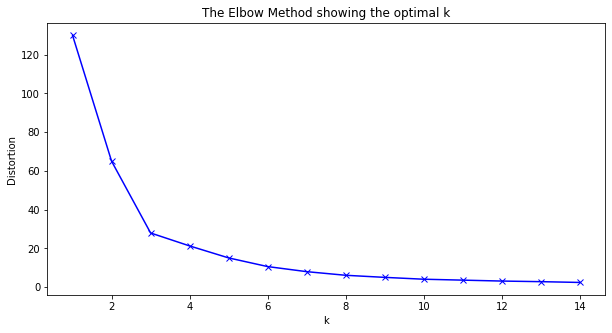

In [ ]:
import matplotlib.pyplot as plt
#Area_cluster = mum_bai_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(init = "k-means++", n_clusters=k)
    kmeanModel.fit(clustering_data)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The Elbow Method suggests 3 as the optimum number of clusters, as the distortion in the data drops suddenly at 3 clusters and very slowly decreases from there

###**Modeling**

In [ ]:
kclusters = 3
kmeanModel = KMeans(init="k-means++", n_clusters=kclusters, random_state=0)
kmeanModel.fit(clustering_data)
cluster_labels = kmeanModel.labels_      
cluster_labels 

array([1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

###**Cluster insights**

In [ ]:
Area_df['Cluster'] = cluster_labels
Area_df.head()

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.0,1
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.0,1
2,Churchgate,18.930000,72.820000,28500.0,25.0,1.0,12.5,1
3,Cuffe Parade,18.910000,72.810000,27500.0,8.0,0.0,8.0,2
4,Navy Nagar,18.901200,72.810100,27500.0,6.0,0.0,6.0,2


In [ ]:
Clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add Selected_Areas to map
for lat, lng, area, cluster in zip(Area_df['Latitude'], Area_df['Longitude'], Area_df['Area'],
                                           Area_df['Cluster']):
    col = 'orange' if cluster==0 else 'red' if cluster==1 else "blue"
    label = '{}, Cluster {}'.format(area ,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= col ,
        fill=True,
        fill_color= col ,
        fill_opacity=0.7,
        parse_html=False).add_to(Clusters_map)      
Clusters_map

In [ ]:
insight_columns = ['Rate','Schools_Colleges','Tutorials_Classes','Startup Opportunity Index','Cluster']
Cluster_insights = Area_df[insight_columns].groupby("Cluster").mean()
Cluster_insights.insert(0, 'No. of Areas', Area_df[['Area','Cluster']].groupby("Cluster").count())
Cluster_insights.columns = ['No. of Areas','Average Property Rate','Average No. of Schools & Colleges','Average No. of Tutorials & Classes',
                            'Startup Opportunity Index']
Cluster_insights

,No. of Areas,Average Property Rate,Average No. of Schools & Colleges,Average No. of Tutorials & Classes,Startup Opportunity Index
Cluster,,,,,
0,45,15847.777778,26.133333,17.622222,1.683511
1,3,35000.000000,22.666667,0.666667,14.166667
2,17,32485.294118,26.647059,9.588235,3.235765


In [ ]:
Cluster_2 = Area_df[Area_df['Cluster'] == 2]
Cluster_2

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
3,Cuffe Parade,18.910000,72.810000,27500.0,8.0,0.0,8.000,2
4,Navy Nagar,18.901200,72.810100,27500.0,6.0,0.0,6.000,2
5,Mahalaxmi,18.983333,72.800000,27500.0,16.0,2.0,5.333,2
6,Bandstand Promenade,19.042718,72.819132,30000.0,16.0,3.0,4.000,2
8,Kemps Corner,18.962900,72.805400,40000.0,39.0,11.0,3.250,2
10,Breach Candy,18.967000,72.805000,43500.0,35.0,10.0,3.182,2
11,Pali Hill,19.068000,72.826000,30000.0,31.0,9.0,3.100,2
14,Gowalia Tank,18.962450,72.809703,31000.0,41.0,14.0,2.733,2
16,Marine Drive,18.944000,72.823000,40000.0,35.0,12.0,2.692,2
18,Marine Lines,18.944700,72.824400,29000.0,40.0,14.0,2.667,2


In [ ]:
Cluster_1 = Area_df[Area_df['Cluster'] == 1]
Cluster_1

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.0,1
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.0,1
2,Churchgate,18.930000,72.820000,28500.0,25.0,1.0,12.5,1


In [ ]:
Cluster_0 = Area_df[Area_df['Cluster'] == 0]
Cluster_0

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
7,Versova,19.120000,72.820000,18000.0,23.0,5.0,3.833,0
9,Mahim,19.035000,72.840000,18500.0,45.0,13.0,3.214,0
12,Nahur,19.157000,72.941000,11600.0,36.0,11.0,3.000,0
13,Thakur village,19.210206,72.872980,11500.0,25.0,8.0,2.778,0
15,Vikhroli,19.110000,72.940000,12000.0,19.0,6.0,2.714,0
17,Sahar,19.098889,72.867222,14750.0,24.0,8.0,2.667,0
19,Four Bungalows,19.124714,72.827210,18000.0,24.0,8.0,2.667,0
21,Parel,18.990000,72.840000,18000.0,23.0,8.0,2.556,0
22,Pali Naka,19.062742,72.829396,21500.0,31.0,12.0,2.385,0
23,Bhandup,19.140000,72.930000,15000.0,28.0,11.0,2.333,0


In [ ]:
#condition_PropertyRateLimit = Cluster_2['Rate'] <= 15000
#Selected_Areas = Cluster_2 [condition_PropertyRateLimit]
Selected_Areas = Cluster_2
Selected_Areas.reset_index(inplace = True, drop = True)
Selected_Areas = Selected_Areas.merge(neighborhood_df, on = ["Area","Latitude","Longitude"], how = "inner")
cols = Selected_Areas.columns.tolist()
cols = cols[0:1] + cols[-1:] + cols[1:-1]
Selected_Areas = Selected_Areas[cols]
Selected_Areas

,Area,Location,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Cuffe Parade,South Mumbai,18.910000,72.810000,27500.0,8.0,0.0,8.000,2
1,Navy Nagar,"Colaba,South Mumbai",18.901200,72.810100,27500.0,6.0,0.0,6.000,2
2,Mahalaxmi,South Mumbai,18.983333,72.800000,27500.0,16.0,2.0,5.333,2
3,Bandstand Promenade,"Bandra,Western Suburbs",19.042718,72.819132,30000.0,16.0,3.0,4.000,2
4,Kemps Corner,South Mumbai,18.962900,72.805400,40000.0,39.0,11.0,3.250,2
5,Breach Candy,South Mumbai,18.967000,72.805000,43500.0,35.0,10.0,3.182,2
6,Pali Hill,"Bandra,Western Suburbs",19.068000,72.826000,30000.0,31.0,9.0,3.100,2
7,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703,31000.0,41.0,14.0,2.733,2
8,Marine Drive,South Mumbai,18.944000,72.823000,40000.0,35.0,12.0,2.692,2
9,Marine Lines,South Mumbai,18.944700,72.824400,29000.0,40.0,14.0,2.667,2


In [ ]:
Selected_Areas_map = folium.Map(location=[19.088493, 72.881756], zoom_start=11)

# add Selected_Areas to map
for lat, lng, area, rate, location in zip(Selected_Areas['Latitude'], Selected_Areas['Longitude'], Selected_Areas['Area'],
                                           Selected_Areas['Rate'], Selected_Areas['Location']):
    label = 'Area: {}, Location: {}, Property Rate: Rs.{}/sq.ft.'.format(area ,location, int(rate))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'blue' ,
        fill=True,
        fill_color= 'blue' ,
        fill_opacity=0.7,
        parse_html=False).add_to(Selected_Areas_map)  
    
Selected_Areas_map

In [ ]:
Selected_Areas1 = Cluster_1
Selected_Areas1.reset_index(inplace = True, drop = True)
Selected_Areas1 = Selected_Areas1.merge(neighborhood_df, on = ["Area","Latitude","Longitude"], how = "inner")
cols = Selected_Areas1.columns.tolist()
cols = cols[0:1] + cols[-1:] + cols[1:-1]
Selected_Areas1 = Selected_Areas1[cols]
Selected_Areas1

,Area,Location,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Walkeshwar,South Mumbai,18.947596,72.795957,43000.0,17.0,0.0,17.0,1
1,Nariman Point,South Mumbai,18.926000,72.823000,33500.0,26.0,1.0,13.0,1
2,Churchgate,South Mumbai,18.930000,72.820000,28500.0,25.0,1.0,12.5,1


In [ ]:
Selected_Areas_map1 = folium.Map(location=[19.088493, 72.881756], zoom_start=11)

# add Selected_Areas to map
for lat, lng, area, rate, location in zip(Selected_Areas1['Latitude'], Selected_Areas1['Longitude'], Selected_Areas1['Area'],
                                           Selected_Areas1['Rate'], Selected_Areas1['Location']):
    label = 'Area: {}, Location: {}, Property Rate: Rs.{}/sq.ft.'.format(area ,location, int(rate))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= 'red' ,
        fill=True,
        fill_color= 'red' ,
        fill_opacity=0.7,
        parse_html=False).add_to(Selected_Areas_map1)  
    
Selected_Areas_map1

In [ ]:
cl0 = Cluster_0[Cluster_0['Startup Opportunity Index']>=2.5]
cl1 = Cluster_1[Cluster_1['Startup Opportunity Index']>=2.5]
cl2 = Cluster_2[Cluster_2['Startup Opportunity Index']>=2.5]
combine = pd.concat([cl0, cl1, cl2], axis=0)
combine

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
7,Versova,19.120000,72.820000,18000.0,23.0,5.0,3.833,0
9,Mahim,19.035000,72.840000,18500.0,45.0,13.0,3.214,0
12,Nahur,19.157000,72.941000,11600.0,36.0,11.0,3.000,0
13,Thakur village,19.210206,72.872980,11500.0,25.0,8.0,2.778,0
15,Vikhroli,19.110000,72.940000,12000.0,19.0,6.0,2.714,0
17,Sahar,19.098889,72.867222,14750.0,24.0,8.0,2.667,0
19,Four Bungalows,19.124714,72.827210,18000.0,24.0,8.0,2.667,0
21,Parel,18.990000,72.840000,18000.0,23.0,8.0,2.556,0
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.000,1
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.000,1


In [ ]:
Selected_Areas_map2 = folium.Map(location=[19.088493, 72.881756], zoom_start=11)

# add Selected_Areas to map
for lat, lng, area, rate, cluster in zip(combine['Latitude'], combine['Longitude'], combine['Area'],
                                           combine['Rate'], combine['Cluster']):
    label = 'Area: {}, Property Rate: Rs.{}/sq.ft.,  Cluster {}'.format(area , int(rate), cluster)
    col = 'orange' if cluster==0 else 'red' if cluster==1 else "blue"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= col ,
        fill=True,
        fill_color= col ,
        fill_opacity=0.7,
        parse_html=False).add_to(Selected_Areas_map2)  
    
Selected_Areas_map2

In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN()
dbscan.fit(clustering_data)
cluster_labels = dbscan.labels_     
cluster_labels

array([-1, -1, -1, -1, -1, -1,  1,  0, -1,  0, -1,  1,  0,  0,  1,  0, -1,
        0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  1,  0,  0,
        0,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
Area_df['Cluster'] = cluster_labels
Area_df.head()

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.0,-1
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.0,-1
2,Churchgate,18.930000,72.820000,28500.0,25.0,1.0,12.5,-1
3,Cuffe Parade,18.910000,72.810000,27500.0,8.0,0.0,8.0,-1
4,Navy Nagar,18.901200,72.810100,27500.0,6.0,0.0,6.0,-1


In [ ]:
Clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add Selected_Areas to map
for lat, lng, area, cluster in zip(Area_df['Latitude'], Area_df['Longitude'], Area_df['Area'],
                                           Area_df['Cluster']):
    col = 'orange' if cluster==0 else 'red' if cluster==1 else "blue"
    label = '{}, Cluster {}'.format(area ,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color= col ,
        fill=True,
        fill_color= col ,
        fill_opacity=0.7,
        parse_html=False).add_to(Clusters_map)      
Clusters_map

In [ ]:
insight_columns = ['Rate','Schools_Colleges','Tutorials_Classes','Startup Opportunity Index','Cluster']
Cluster_insights = Area_df[insight_columns].groupby("Cluster").mean()
Cluster_insights.insert(0, 'No. of Areas', Area_df[['Area','Cluster']].groupby("Cluster").count())
Cluster_insights.columns = ['No. of Areas','Average Property Rate','Average No. of Schools & Colleges','Average No. of Tutorials & Classes',
                            'Startup Opportunity Index']
Cluster_insights

,No. of Areas,Average Property Rate,Average No. of Schools & Colleges,Average No. of Tutorials & Classes,Startup Opportunity Index
Cluster,,,,,
-1,11,35795.454545,24.272727,5.454545,6.882727
0,45,15847.777778,26.133333,17.622222,1.683511
1,9,29277.777778,28.222222,11.666667,2.422000


In [ ]:
Cluster_neg1 = Area_df[Area_df['Cluster'] == -1]
Cluster_neg1

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
0,Walkeshwar,18.947596,72.795957,43000.0,17.0,0.0,17.000,-1
1,Nariman Point,18.926000,72.823000,33500.0,26.0,1.0,13.000,-1
2,Churchgate,18.930000,72.820000,28500.0,25.0,1.0,12.500,-1
3,Cuffe Parade,18.910000,72.810000,27500.0,8.0,0.0,8.000,-1
4,Navy Nagar,18.901200,72.810100,27500.0,6.0,0.0,6.000,-1
5,Mahalaxmi,18.983333,72.800000,27500.0,16.0,2.0,5.333,-1
8,Kemps Corner,18.962900,72.805400,40000.0,39.0,11.0,3.250,-1
10,Breach Candy,18.967000,72.805000,43500.0,35.0,10.0,3.182,-1
16,Marine Drive,18.944000,72.823000,40000.0,35.0,12.0,2.692,-1
20,Altamount Road,18.968100,72.809500,45000.0,36.0,13.0,2.571,-1


In [ ]:
Cluster_0 = Area_df[Area_df['Cluster'] == 0]
Cluster_0

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
7,Versova,19.120000,72.820000,18000.0,23.0,5.0,3.833,0
9,Mahim,19.035000,72.840000,18500.0,45.0,13.0,3.214,0
12,Nahur,19.157000,72.941000,11600.0,36.0,11.0,3.000,0
13,Thakur village,19.210206,72.872980,11500.0,25.0,8.0,2.778,0
15,Vikhroli,19.110000,72.940000,12000.0,19.0,6.0,2.714,0
17,Sahar,19.098889,72.867222,14750.0,24.0,8.0,2.667,0
19,Four Bungalows,19.124714,72.827210,18000.0,24.0,8.0,2.667,0
21,Parel,18.990000,72.840000,18000.0,23.0,8.0,2.556,0
22,Pali Naka,19.062742,72.829396,21500.0,31.0,12.0,2.385,0
23,Bhandup,19.140000,72.930000,15000.0,28.0,11.0,2.333,0


In [ ]:
Cluster_1 = Area_df[Area_df['Cluster'] == 1]
Cluster_1

,Area,Latitude,Longitude,Rate,Schools_Colleges,Tutorials_Classes,Startup Opportunity Index,Cluster
6,Bandstand Promenade,19.042718,72.819132,30000.0,16.0,3.0,4.000,1
11,Pali Hill,19.068000,72.826000,30000.0,31.0,9.0,3.100,1
14,Gowalia Tank,18.962450,72.809703,31000.0,41.0,14.0,2.733,1
18,Marine Lines,18.944700,72.824400,29000.0,40.0,14.0,2.667,1
29,Kherwadi,19.055300,72.831400,27500.0,24.0,10.0,2.182,1
31,Worli,19.000000,72.815000,27500.0,17.0,7.0,2.125,1
37,Ballard Estate,18.950000,72.840000,29000.0,33.0,18.0,1.737,1
40,Lower Parel,18.995278,72.830000,28750.0,23.0,13.0,1.643,1
42,Prabhadevi,19.016600,72.829500,30750.0,29.0,17.0,1.611,1
